In [900]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils


# Loading the corneal images

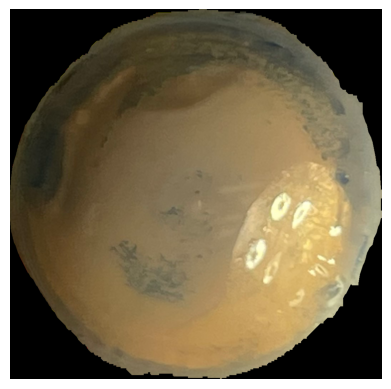

In [905]:
path = r'your image path'
img = cv2.imread(path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # 关闭坐标轴
plt.show()

# Calculating the area of the cornea image and getting the coordinates of the pixels relative to the cornea.

In [902]:
# Calculating the area of cornea (Counting the number of pixels)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_image[gray_image != 0] = 255

unique_values, counts = np.unique(gray_image, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Pixel value {value}: Count = {count}")

Pixel value 0: Count = 242266
Pixel value 255: Count = 841411


In [903]:
#Obtaining the coordinates of the pixels occupied by the cornea
zero_pixel_coords = np.column_stack(np.where(gray_image == 0))

# Segment the parts which clinical guys are concerned about in the cornea.
* Gaussian Blur: Smoothes the image, reducing noise.
* Adaptive thresholding: Used for subsequent thresholding operations 
* Determining foreground, background, and unknown regions 
* Watershed algorithm: Utilizes the watershed algorithm to segment individual connected components within the foreground region.

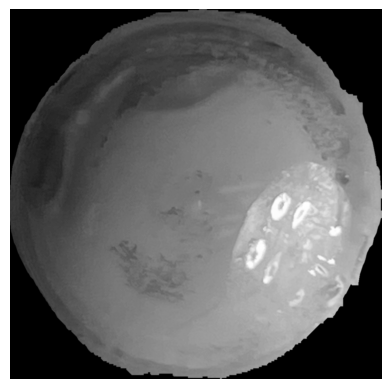

In [906]:
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur_image = cv2.GaussianBlur(gray_image, (3,3), 0)
plt.imshow(blur_image,cmap='gray')
plt.axis('off')  
plt.show()

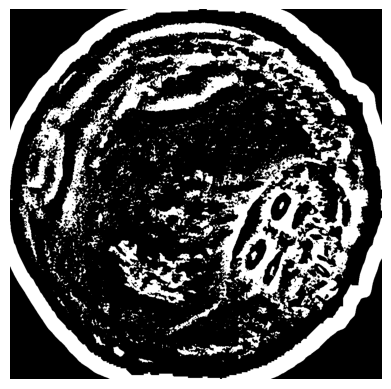

In [912]:
img_ada_mean = cv2.adaptiveThreshold(blur_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 77, 3)
plt.imshow(img_ada_mean,cmap='gray')
plt.axis('off') 
plt.show()

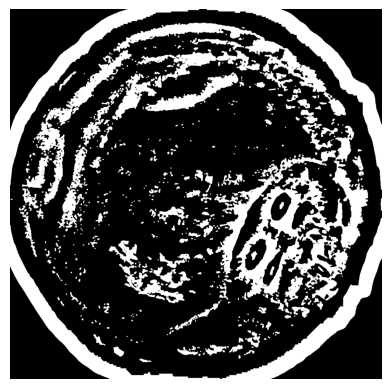

In [913]:
kernel_3X3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
binary_after_open = cv2.morphologyEx(img_ada_mean, cv2.MORPH_OPEN, kernel_3X3)
plt.imshow(binary_after_open,cmap='gray')
plt.axis('off') 
plt.show()

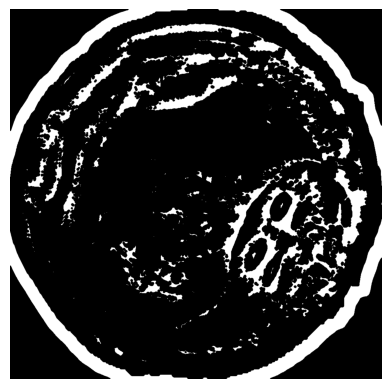

In [914]:
dist = cv2.distanceTransform(binary_after_open, cv2.DIST_L2, 3)   #float32的浮点型数组，dist.shape返回(312, 252),dist是一个灰度图像
th, sure_fg = cv2.threshold(dist, 0.1*dist.max(), 255, cv2.THRESH_BINARY) #把dist阈值化处理，变成一个0和255的二值图像，此时就是我们要的确定前景
sure_fg = np.uint8(sure_fg)
plt.imshow(sure_fg,cmap='gray')
plt.axis('off')  
plt.show()

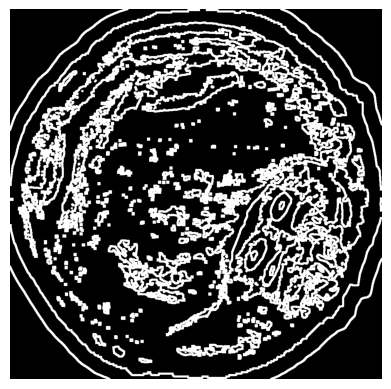

In [915]:
sure_bg = cv2.dilate(binary_after_open, kernel=np.ones((3,3), np.uint8), iterations=3) #对前景膨胀来确定背景
unknown = cv2.subtract(sure_bg, sure_fg) 
plt.imshow(unknown,cmap='gray')
plt.axis('off')  
plt.show()

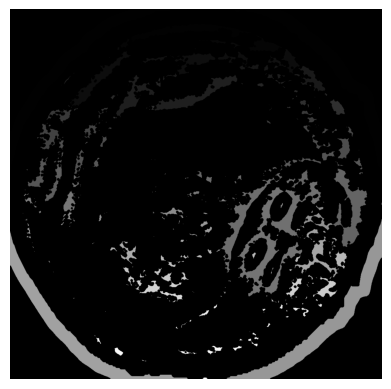

In [916]:
ret, labels = cv2.connectedComponents(sure_fg)
labels = labels+1
labels[unknown==255]=0 

plt.imshow(labels,cmap='gray')
plt.axis('off')  
plt.show()

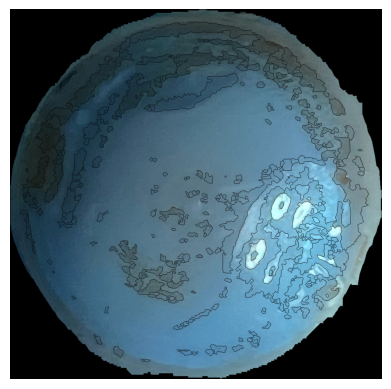

In [917]:
segmentation = img.copy()
markers = cv2.watershed(segmentation,labels)
segmentation[markers==-1]=[0,0,0]

plt.imshow(segmentation)
plt.axis('off')  
plt.show()

# Calculate concentric circles
We first find the outer contours of the binary image, then use these contours to determine the center and radius of the circle. We sequentially draw circles with radii of 1/4, 1/2, and 3/4 of the radius of the minimum enclosing circle of the outer contour.

In [918]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Add Gaussian Blur
blur_image = cv2.GaussianBlur(gray, (71,71), 11)
# Using Otsu threshold methods
ret3, th3 = cv2.threshold(blur_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [919]:
 # Find contours in the thresholded image
cnts = cv2.findContours(th3.copy(), cv2.RETR_EXTERNAL,
cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [920]:
# Loop over the contours
for c in cnts:
    # Compute the center of the contour
    M = cv2.moments(c)
    try:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    except ZeroDivisionError:
        cX = 0
        cY = 0
    (x, y), radius = cv2.minEnclosingCircle(c)
    (x, y, radius) = np.int0((x, y, radius))
    # Draw the contour and center of the shape on the image
    cv2.circle(segmentation, (x, y), radius, (255, 0, 0), 2)
    cv2.circle(segmentation, (x, y), int(radius/4), (255, 0, 0), 2)
    cv2.circle(segmentation, (x, y), int(radius/2), (255, 0, 0), 2)
    cv2.circle(segmentation, (x, y), int((3*radius)/4), (255, 0, 0), 2)
    #cv2.drawContours(segmentation,[c],-1,(255,0,0),2)
    # Draw center of circle
    cv2.circle(segmentation,(x, y),7,(0,0,0),-1)
    cv2.putText(segmentation,"center",(x-20,y-20),
    cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),2)
    

/var/folders/cz/y3vkwv9d6hg7yxpf9kjt_70m0000gn/T/ipykernel_77565/25722976.py:12: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  (x, y, radius) = np.int0((x, y, radius))


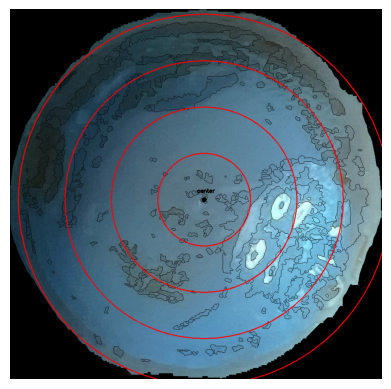

In [921]:
plt.imshow(segmentation)
plt.axis('off') 
plt.show()

In [922]:
save_path = r'Saving image Path'
cv2.imwrite(save_path, segmentation)

True

# Marking the segmentation parts using solid colors (Blue)

In [923]:
markers = markers.astype(np.uint8)
ret, m2 = cv2.threshold(markers, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(m2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
mask = img.copy()


In [924]:
areas = list()
for i in range(len(contours)):
    area = cv2.contourArea(contours[i], False)
    areas.append(area)
sorted_list = sorted(areas, reverse=True)
print(sorted_list)
area_avg = np.average(sorted_list)
print(area_avg)
result = [x for x in sorted_list if x > area_avg]
sorted_result =sorted(result, reverse=True)

[1081596.0, 839874.5, 75004.5, 40776.5, 39914.0, 36992.0, 33896.0, 33566.0, 25893.5, 24411.0, 23719.5, 22183.5, 18151.0, 8403.0, 8051.5, 7669.0, 7644.5, 7392.5, 6425.0, 6305.5, 5333.5, 5058.0, 5013.5, 4856.0, 4763.0, 3984.0, 3602.0, 3183.5, 3131.0, 2897.0, 2854.0, 2749.0, 2656.5, 2620.5, 2417.0, 2230.5, 2045.5, 1835.0, 1748.0, 1677.0, 1392.5, 1389.5, 1389.5, 1323.0, 1161.5, 1128.5, 1118.5, 1100.5, 1021.5, 970.0, 940.0, 910.5, 908.0, 877.0, 858.0, 844.5, 818.0, 689.5, 658.0, 658.0, 652.0, 587.5, 559.0, 557.5, 542.0, 538.0, 526.5, 516.0, 505.0, 474.0, 468.0, 451.5, 446.0, 443.5, 441.5, 441.0, 436.0, 424.5, 416.5, 406.0, 405.0, 402.0, 400.0, 394.0, 392.0, 364.0, 359.5, 358.5, 357.0, 351.0, 350.0, 350.0, 348.0, 346.5, 334.5, 323.0, 321.5, 314.0, 307.0, 306.5, 302.0, 299.5, 299.5, 296.5, 296.5, 280.0, 278.5, 266.5, 262.5, 259.5, 252.5, 252.5, 250.0, 244.5, 242.5, 242.0, 233.5, 226.5, 226.5, 224.5, 217.0, 217.0, 215.5, 213.0, 213.0, 203.5, 202.5, 198.5, 194.5, 194.0, 187.5, 187.0, 185.0, 184

In [925]:
img_contours = []
for i in range(len(contours)):
    img_temp = np.zeros(mask.shape, np.uint8)
    img_contours.append(img_temp)

    area = cv2.contourArea(contours[i], False)
    
    if area <= 10*area_avg:
    
        cv2.drawContours(mask, contours, i, (0, 0, 255), cv2.FILLED)

<class 'numpy.ndarray'>


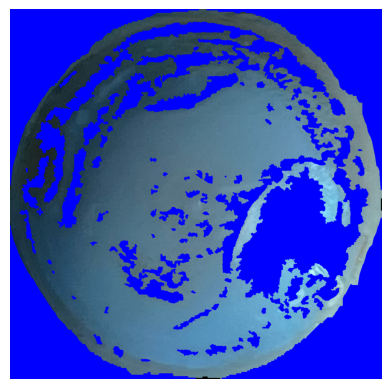

In [926]:

print(type(mask))
plt.imshow(mask)
plt.axis('off')  # 关闭坐标轴
plt.show()

<class 'numpy.ndarray'>


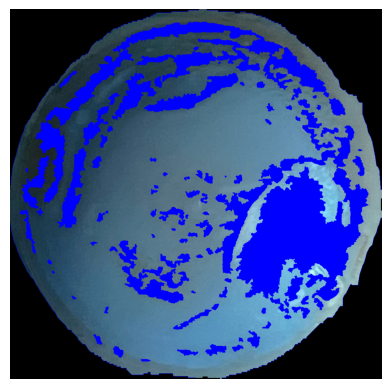

In [927]:
for coord in zero_pixel_coords:
    mask[coord[0], coord[1]] = [0, 0, 0]
print(type(mask))
plt.imshow(mask)
plt.axis('off')  # 关闭坐标轴
plt.show()

In [928]:
cv2.imwrite("Saving image path", mask)


True

(1039, 1043, 3)


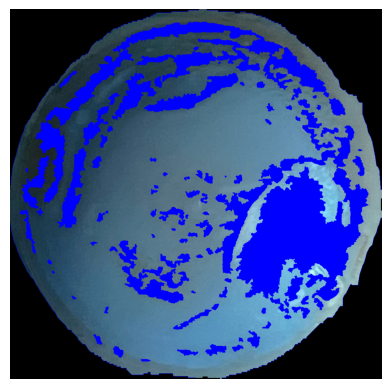

In [929]:
path = r'Loading the image used solid color to segment the cornea.'
img = cv2.imread(path)
print(img.shape)
plt.imshow(img)
plt.axis('off')  # 关闭坐标轴
plt.show()

# Calculating the ratio of the segment to the cornea

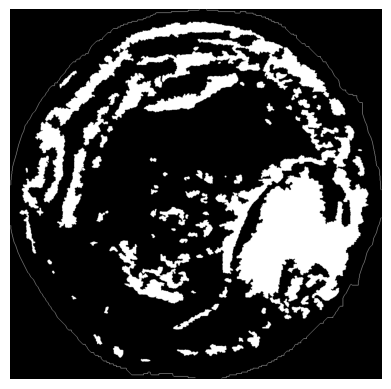

In [930]:
target_color = np.array([0, 0, 255])
mask = np.all(img == target_color, axis=-1)
img[mask] = [255, 255, 255]
img[~mask] = [0, 0, 0]
plt.imshow(img)
plt.axis('off')  
plt.show()

In [931]:
_ = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
unique_values, counts = np.unique(_, return_counts=True)
print(unique_values)
for value, count in zip(unique_values, counts):
    print(f"Pixel value {value}: Count = {count}")

[  0 255]
Pixel value 0: Count = 863806
Pixel value 255: Count = 219871


# Calculating the ratio of the segment to the cornea for different radii of the inscribed circle.

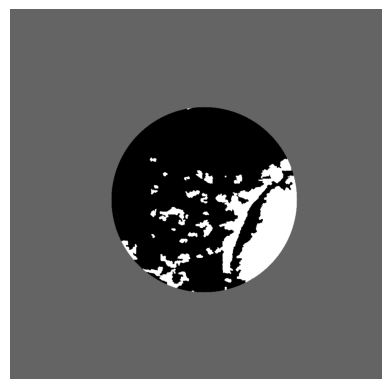

In [933]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask_1 = np.zeros_like(gray)
quarter_radius = int(radius/2)
start_x = max(0, x - quarter_radius)
end_x = min(mask_1.shape[1], x + quarter_radius)
start_y = max(0, y - quarter_radius)
end_y = min(mask_1.shape[0], y + quarter_radius)

cv2.circle(mask_1, (x, y), quarter_radius, (255, 255, 255), thickness=cv2.FILLED)

cropped_circle = cv2.bitwise_and(gray, gray, mask=mask_1)

cropped_circle[~(mask_1 == 255)] = 100


cropped_circle[cropped_circle == 255] = 255

plt.imshow(cv2.cvtColor(cropped_circle, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()


In [934]:
unique_values, counts = np.unique(cropped_circle, return_counts=True)
print(unique_values)
for value, count in zip(unique_values, counts):
    print(f"Pixel value {value}: Count = {count}")

[  0 100 255]
Pixel value 0: Count = 162204
Pixel value 100: Count = 871320
Pixel value 255: Count = 50153
